<h1>A Study of COVID-19 Cases</h1>
<h2>Objective of Experiment</h2>
The goal and objective of this experiment is to look at and compare results of SARS-COVID-2 across multiple countries and across each state. The data for this experiment comes from the John Hopkins University data repository, which gathers data from seven different sources and allows for it to be studied. This journal will try to compare this data not only to show the difference of how each government handled the virus, but to previous pandemics and the influenza.

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import glob
import us
import math

import copy
import random

import matplotlib
import matplotlib.pyplot as plt

import git

import time
%matplotlib inline

<h2>Data File Location and Extraction</h2>
Set the location of data for cases collected by CSSE for cases and deaths worldwide as well as data that has been collected for the United States. Goal will be to observe and compare the differences amongst a group of 15 countries (Brazil, Canada, China, Germany, Finland, India, Iran, Italy, Japan, South Korea, Norway, Switzerland, Spain, United Kingdom, United States) to each other and compare each state. The goal is to have a visible representation of the effects of the virus and compare how it has been handled across different governments with the amount of time they had to react. To pull and use the data that will be displayed in the following sections, please see README for the Johns Hopkins University data repository if unable to use the following code to clone or pull the data from the repository.

In [2]:
try:
    updateCOVID=git.cmd.Git('COVID-19/')
    updateCOVID.pull()
except:
    try:
        git.Git(os.getcwd()).clone('https://github.com/CSSEGISandData/COVID-19.git')
        print('Data Repository cloned and placed in working directory')
    except:
        print('Please ensure that you have a connection to the interent to either clone or pull in data directory')
else:
    print('Everything up-to-date')


Everything up-to-date


<h3>Extracting Data</h3>
Once this data is available for the systam DataFrames are created from reading the csv files for the number of cases, recoveries, and deaths for the United States and global. The first twenty-five rows of each dataset is provided for viewing, and visual verification that everything is correctly setup.

In [3]:
dataCSSEPath=r'COVID-19\csse_covid_19_data\csse_covid_19_time_series'

dataUSCases=pd.read_csv(dataCSSEPath + r'\time_series_covid19_confirmed_US.csv')
dataUSDeaths=pd.read_csv(dataCSSEPath + r'\time_series_covid19_deaths_US.csv')
dataGlobalCases=pd.read_csv(dataCSSEPath + r'\time_series_covid19_confirmed_global.csv')
dataGlobalDeaths=pd.read_csv(dataCSSEPath + r'\time_series_covid19_deaths_global.csv')

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
dataUSCases[0:25]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,...,307,309,310,310,310,312,312,313,314,314
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,...,31,31,31,33,33,33,36,36,37,37
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.220800,-66.590100,...,8745,8862,9137,9366,9654,10010,10123,10379,10574,11120
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.335800,-64.896300,...,122,144,153,167,181,206,206,243,249,263
5,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,643,653,662,676,698,715,733,743,765,773
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,1039,1114,1170,1207,1277,1341,1396,1499,1579,1669
7,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,362,367,377,394,399,402,413,426,444,448
8,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,198,208,215,221,224,227,232,238,243,251
9,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,258,273,281,296,320,331,344,367,395,406


In [5]:
dataUSDeaths[0:25]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,...,5,5,5,5,5,5,5,5,5,5
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,...,2,2,2,2,2,2,2,2,2,2
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.220800,-66.590100,...,159,159,159,167,167,167,169,171,172,177
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.335800,-64.896300,...,6,6,6,6,6,6,6,6,6,6
5,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,12,13,14,14,15,15,17,18,19,20
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,9,10,11,11,11,11,11,12,13,13
7,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,2,2,2,2,2,2,3,3,3,3
8,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,1,1,1,1,1,1,2,2,2,2
9,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,1,1,1,1,1,1,1,1,1,1


In [6]:
dataGlobalCases[0:25]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,33594,33908,34194,34366,34451,34455,34740,34994,35070,35229
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,3106,3188,3278,3371,3454,3571,3667,3752,3851,3906
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,17348,17808,18242,18712,19195,19689,20216,20770,21355,21948
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,855,855,855,855,855,858,861,862,877,880
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,386,396,458,462,506,525,541,576,607,638
5,NaN,Antigua and Barbuda,17.060800,-61.796400,0,0,0,0,0,0,...,70,73,74,74,74,74,74,74,74,76
6,NaN,Argentina,-38.416100,-63.616700,0,0,0,0,0,0,...,87030,90693,94060,97509,100166,103265,106910,111146,114783,119301
7,NaN,Armenia,40.069100,45.038200,0,0,0,0,0,0,...,29820,30346,30903,31392,31969,32151,32490,33005,33559,34001
8,Australian Capital Territory,Australia,-35.473500,149.012400,0,0,0,0,0,0,...,112,113,113,113,113,113,113,113,113,113
9,New South Wales,Australia,-33.868800,151.209300,0,0,0,0,3,4,...,3453,3467,3474,3478,3492,3505,3517,3527,3535,3550


In [7]:
dataGlobalDeaths[0:25]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,936,957,971,994,1010,1012,1048,1094,1113,1147
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,83,83,85,89,93,95,97,101,104,107
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,978,988,996,1004,1011,1018,1028,1040,1052,1057
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,52,52,52,52,52,52,52,52,52,52
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,21,22,23,23,26,26,26,27,28,29
5,NaN,Antigua and Barbuda,17.060800,-61.796400,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
6,NaN,Argentina,-38.416100,-63.616700,0,0,0,0,0,0,...,1694,1720,1774,1810,1845,1903,1968,2050,2112,2178
7,NaN,Armenia,40.069100,45.038200,0,0,0,0,0,0,...,521,535,546,559,565,573,581,592,607,620
8,Australian Capital Territory,Australia,-35.473500,149.012400,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
9,New South Wales,Australia,-33.868800,151.209300,0,0,0,0,0,0,...,49,49,49,49,49,49,49,49,49,49


<h2>Creating Methods for States</h2>
The following methods provided below will be used to create the plots that will be used to display the number of cases, recoveries, deaths, and mortality rates in the United States tracked since the 21st of Janurary. Each method defined here will be able to either take in a single state to be used as a case study, or plot each state to do side-by-side comparisons.

In [70]:
def plotCasesByState(state=None, byPopDensity=False, logScale=False):
    i=0
    maxCases=0
    plt.clf()
    if byPopDensity:
        return
    else:
        if(state==None):
            states = us.states.STATES
            rows=10
            cols=math.ceil(len(states)/rows)
            fig, axs = plt.subplots(rows,cols,figsize=(20,40))
            i=0
            for state in states:
                data=np.array(np.sum(dataUSCases[dataUSCases.Province_State==state.name].T[11:], axis=1))
                if logScale:
                    data=np.log(data)
                    data[data==math.nan]=0
                axs[int(i/cols), i%cols].plot(data)
                axs[int(i/cols),i%cols].set_title('Cases in ' + state.name)
                if(i%5==0):
                    axs[int(i/cols),i%cols].set_ylabel('Number of Cases')
                if(int(i/cols)==rows-1):
                    axs[int(i/cols),i%cols].set_xlabel('Day of SARS-COVID-2')
                i+=1
                if np.max(np.max(data)) > maxCases:
                    maxCases=np.max(np.max(data))
                    
            for ax in axs.flat:
                ax.set_ylim([0, 1.1*maxCases])
            
            fig.tight_layout(rect=[0,0.3,1,0.95])

        else:
            data=np.array(np.sum(dataUSCases[dataUSCases.Province_State==state.name].T[11:], axis=1))
            if logScale:
                data=np.log(data)
                data[data==math.nan]=0
            plt.title(state)
            plt.ylabel('Number of Cases for SARS-COVID-2')
            plt.xlabel('Day of SARS-COVID-2')
            plt.plot(data)
        
    plt.show()

In [75]:
def plotDeathsByState(state=None, byPopDensity=False, logScale=False):
    i=0
    maxDeaths=0
    plt.clf()
    if byPopDensity:
        return
    else:
        if(state==None):
            states = us.states.STATES
            rows=10
            cols=math.ceil(len(states)/rows)
            fig, axs = plt.subplots(rows,cols,figsize=(20,40))
            i=0
            for state in states:
                data=np.array(np.sum(dataUSDeaths[dataUSDeaths.Province_State==state.name].T[12:], axis=1))
                if logScale:
                    data=np.log(data)
                    data[data==math.nan]=0
                axs[int(i/cols), i%cols].plot(data)
                axs[int(i/cols), i%cols].set_title('Deaths in ' + state.name)
                if(i%cols==0):
                    axs[int(i/cols),i%cols].set_ylabel('Number of Deaths')
                if(int(i/cols)==rows-1):
                    axs[int(i/cols),i%cols].set_xlabel('Day of SARS-COVID-2')
                i+=1
                if np.max(np.max(data)) > maxDeaths:
                    maxDeaths=np.max(np.max(data))
                    
            for ax in axs.flat:
                ax.set_ylim([0, 1.1*maxDeaths])
            
            fig.tight_layout(rect=[0,0.3,1,0.95])

        else:
            data=np.array(np.sum(dataUSDeaths[dataUSDeaths.Province_State==state.name].T[12:], axis=1))
            if logScale:
                data=np.log(data)
                data[data==math.nan]=0
            plt.title(state)
            plt.ylabel('Number of Deaths for SARS-COVID-2')
            plt.xlabel('Day of SARS-COVID-2')
            plt.plot(data)
        
    plt.show()

In [76]:
def plotMortalityRateByState(state=None, byPopDensity=False):
    i=0
    maxRate=0
    plt.clf()
    if byPopDensity:
        return
    else:
        if(state==None):
            states = us.states.STATES
            rows=10
            cols=math.ceil(len(states)/rows)
            fig, axs = plt.subplots(rows,cols,figsize=(20,40))
            i=0
            fig.suptitle('Mortality Rate of SARS-COVID-2', fontsize='xx-large')
            for state in states:
                cases=np.array(np.sum(dataUSCases[dataUSCases.Province_State==state.name].T[11:], axis=1))
                deaths=np.array(np.sum(dataUSDeaths[dataUSDeaths.Province_State==state.name].T[12:], axis=1))
                data=deaths/cases*100
                axs[int(i/cols), i%cols].plot(data)
                axs[int(i/cols), i%cols].set_title('Mortality Rate in ' + state.name)
                if(i%cols==0):
                    axs[int(i/cols),i%cols].set_ylabel('Mortality Rate (%)')
                if(int(i/cols)==rows-1):
                    axs[int(i/cols),i%cols].set_xlabel('Day of SARS-COVID-2')
                i+=1
                if np.max(np.max(data)) > maxRate:
                    maxRate=np.max(np.max(data))
                    
            for ax in axs.flat:
                ax.set_ylim([0, 1.1*maxRate])
            
            fig.tight_layout(rect=[0,0.3,1,0.95])

        else:
            cases=np.array(np.sum(dataUSCases[dataUSCases.Province_State==state.name].T[11:], axis=1))
            deaths=np.array(np.sum(dataUSDeaths[dataUSDeaths.Province_State==state.name].T[12:], axis=1))
            data=deaths/cases*100
            plt.title('Mortality Rate of SARS-COVID-2' + state.name)
            plt.ylabel('Mortality Rate (%)')
            plt.xlabel('Day of SARS-COVID-2')
            plt.plot(data)
        
    plt.show()

<h2>Creating Methods for Countries</h2>
Similar to the methods that are used for creating the plots that will be used for a state-by-state comparison, the same will be done to either show off a country for a case study or compare one of the ten listed above for a comparison to how well each of the countries were able to handle the virus.

In [66]:
def plotCasesByCountry(country=None, byPopDensity=False, logScale=False):
    if byPopDensity:
        return
    else:
        if len(country)>1:
            maxCases=0
            rows=5
            cols=math.ceil(len(country)/rows)
            fig, axs = plt.subplots(rows,cols,figsize=(20,40))
            i=0
            fig.suptitle('Number of Cases of SARS-COVID-2', fontsize='xx-large')
            for cntry in country:
                cases=np.array(np.sum(dataGlobalCases[dataGlobalCases['Country/Region']==cntry].T[11:], axis=1))
                if logScale:
                    cases=np.log(cases)
                    cases[cases==math.nan]=0
                axs[int(i/cols), i%cols].plot(cases)
                axs[int(i/cols), i%cols].set_title('Cases in ' + cntry)
                if(i%cols==0):
                    axs[int(i/cols),i%cols].set_ylabel('Cases')
                if(int(i/cols)==rows-1):
                    axs[int(i/cols),i%cols].set_xlabel('Day of SARS-COVID-2')
                i+=1
                if np.max(np.max(cases)) > maxCases:
                    maxCases=np.max(np.max(cases))
                    
            for ax in axs.flat:
                ax.set_ylim([0, 1.1*maxCases])
            
            fig.tight_layout(rect=[0,0.3,1,0.95])
            
        elif country==None:
            return
        
        else:
            data=np.array(np.sum(dataGlobalCases[dataGlobalCases['Country/Region']==country].T[11:], axis=1))
            plt.title(country)
            plt.ylabel('Cases')
            plt.xlabel('Day of SARS-COVID-2')
            plt.plot(data)
        
    plt.show()

In [67]:
def plotDeathsByCountry(country=None, byPopDensity=False, logScale=False):
    if byPopDensity:
        return
    else:
        if len(country)>1:
            maxDeaths=0
            rows=5
            cols=math.ceil(len(country)/rows)
            fig, axs = plt.subplots(rows,cols,figsize=(20,40))
            i=0
            fig.suptitle('Number of Deaths for SARS-COVID-2', fontsize='xx-large')
            for cntry in country:
                deaths=np.array(np.sum(dataGlobalDeaths[dataGlobalDeaths['Country/Region']==cntry].T[11:], axis=1))
                if logScale:
                    deaths=np.log(deaths)
                    deaths[deaths==math.nan]=0
                axs[int(i/cols), i%cols].plot(deaths)
                axs[int(i/cols), i%cols].set_title('Deaths in ' + cntry)
                if(i%cols==0):
                    axs[int(i/cols),i%cols].set_ylabel('Deaths')
                if(int(i/cols)==4):
                    axs[int(i/cols),i%cols].set_xlabel('Day of SARS-COVID-2')
                i+=1
                if np.max(np.max(deaths)) > maxDeaths:
                    maxDeaths=np.max(np.max(deaths))
                    
            for ax in axs.flat:
                ax.set_ylim([0, 1.1*maxDeaths])
            
            fig.tight_layout(rect=[0,0.3,1,0.95])
            
        elif country==None:
            return
        
        else:
            data=np.array(np.sum(dataGlobalDeaths[dataGlobalDeaths['Country/Region']==country].T[11:], axis=1))
            plt.title(country)
            plt.ylabel('Deaths')
            plt.xlabel('Day of SARS-COVID-2')
            plt.plot(data)
        
    plt.show()

In [68]:
def plotMortalityByCountry(country=None, byPopDensity=False):
    if byPopDensity:
        return
    else:
        if len(country)>1:
            maxRate=0
            rows=5
            cols=math.ceil(len(country)/rows)
            fig, axs = plt.subplots(rows,cols,figsize=(20,40))
            i=0
            fig.suptitle('Number of Deaths for SARS-COVID-2', fontsize='xx-large')
            for cntry in country:
                cases=np.array(np.sum(dataGlobalCases[dataGlobalCases['Country/Region']==cntry].T[11:], axis=1))
                deaths=np.array(np.sum(dataGlobalDeaths[dataGlobalDeaths['Country/Region']==cntry].T[11:], axis=1))
                rate=deaths/cases
                axs[int(i/cols), i%cols].plot(rate)
                axs[int(i/cols), i%cols].set_title('Mortality Rate in ' + cntry)
                if(i%cols==0):
                    axs[int(i/cols),i%cols].set_ylabel('Mortality Rate (%)')
                if(int(i/cols)==rows-1):
                    axs[int(i/cols),i%cols].set_xlabel('Day of SARS-COVID-2')
                i+=1
                if np.max(np.max(rate)) > maxRate:
                    maxRate=np.max(np.max(rate))
                    
            for ax in axs.flat:
                ax.set_ylim([0, 1.1*maxRate])
            
            fig.tight_layout(rect=[0,0.3,1,0.95])
            
        elif country==None:
            return
        else:
            cases=np.array(np.sum(dataGlobalCases[dataGlobalCases['Country/Region']==country].T[11:], axis=1))
            deaths=np.array(np.sum(dataGlobalDeaths[dataGlobalDeaths['Country/Region']==country].T[11:], axis=1))
            rate=deaths/cases
            plt.title(country)
            plt.ylabel('Mortality Rate for SARS-COVID-2')
            plt.xlabel('Day of SARS-COVID-2')
            plt.plot(rate)
        
    plt.show()

<h2>Graphing Results</h2>
The following sections will contain the graphs based on the data provided by Johns Hopkins University. The first set show the number of cases, deaths, and rate of mortality in the United States as we have gotten further into the pandemic. After each section I will comment on some of the key states that have been of media publicity: Georgia, Florida, Arizona, New York, Texas, Washington, and California.

<h3>Results by State</h3>

<h4>Raw Data</h4>

<Figure size 432x288 with 0 Axes>

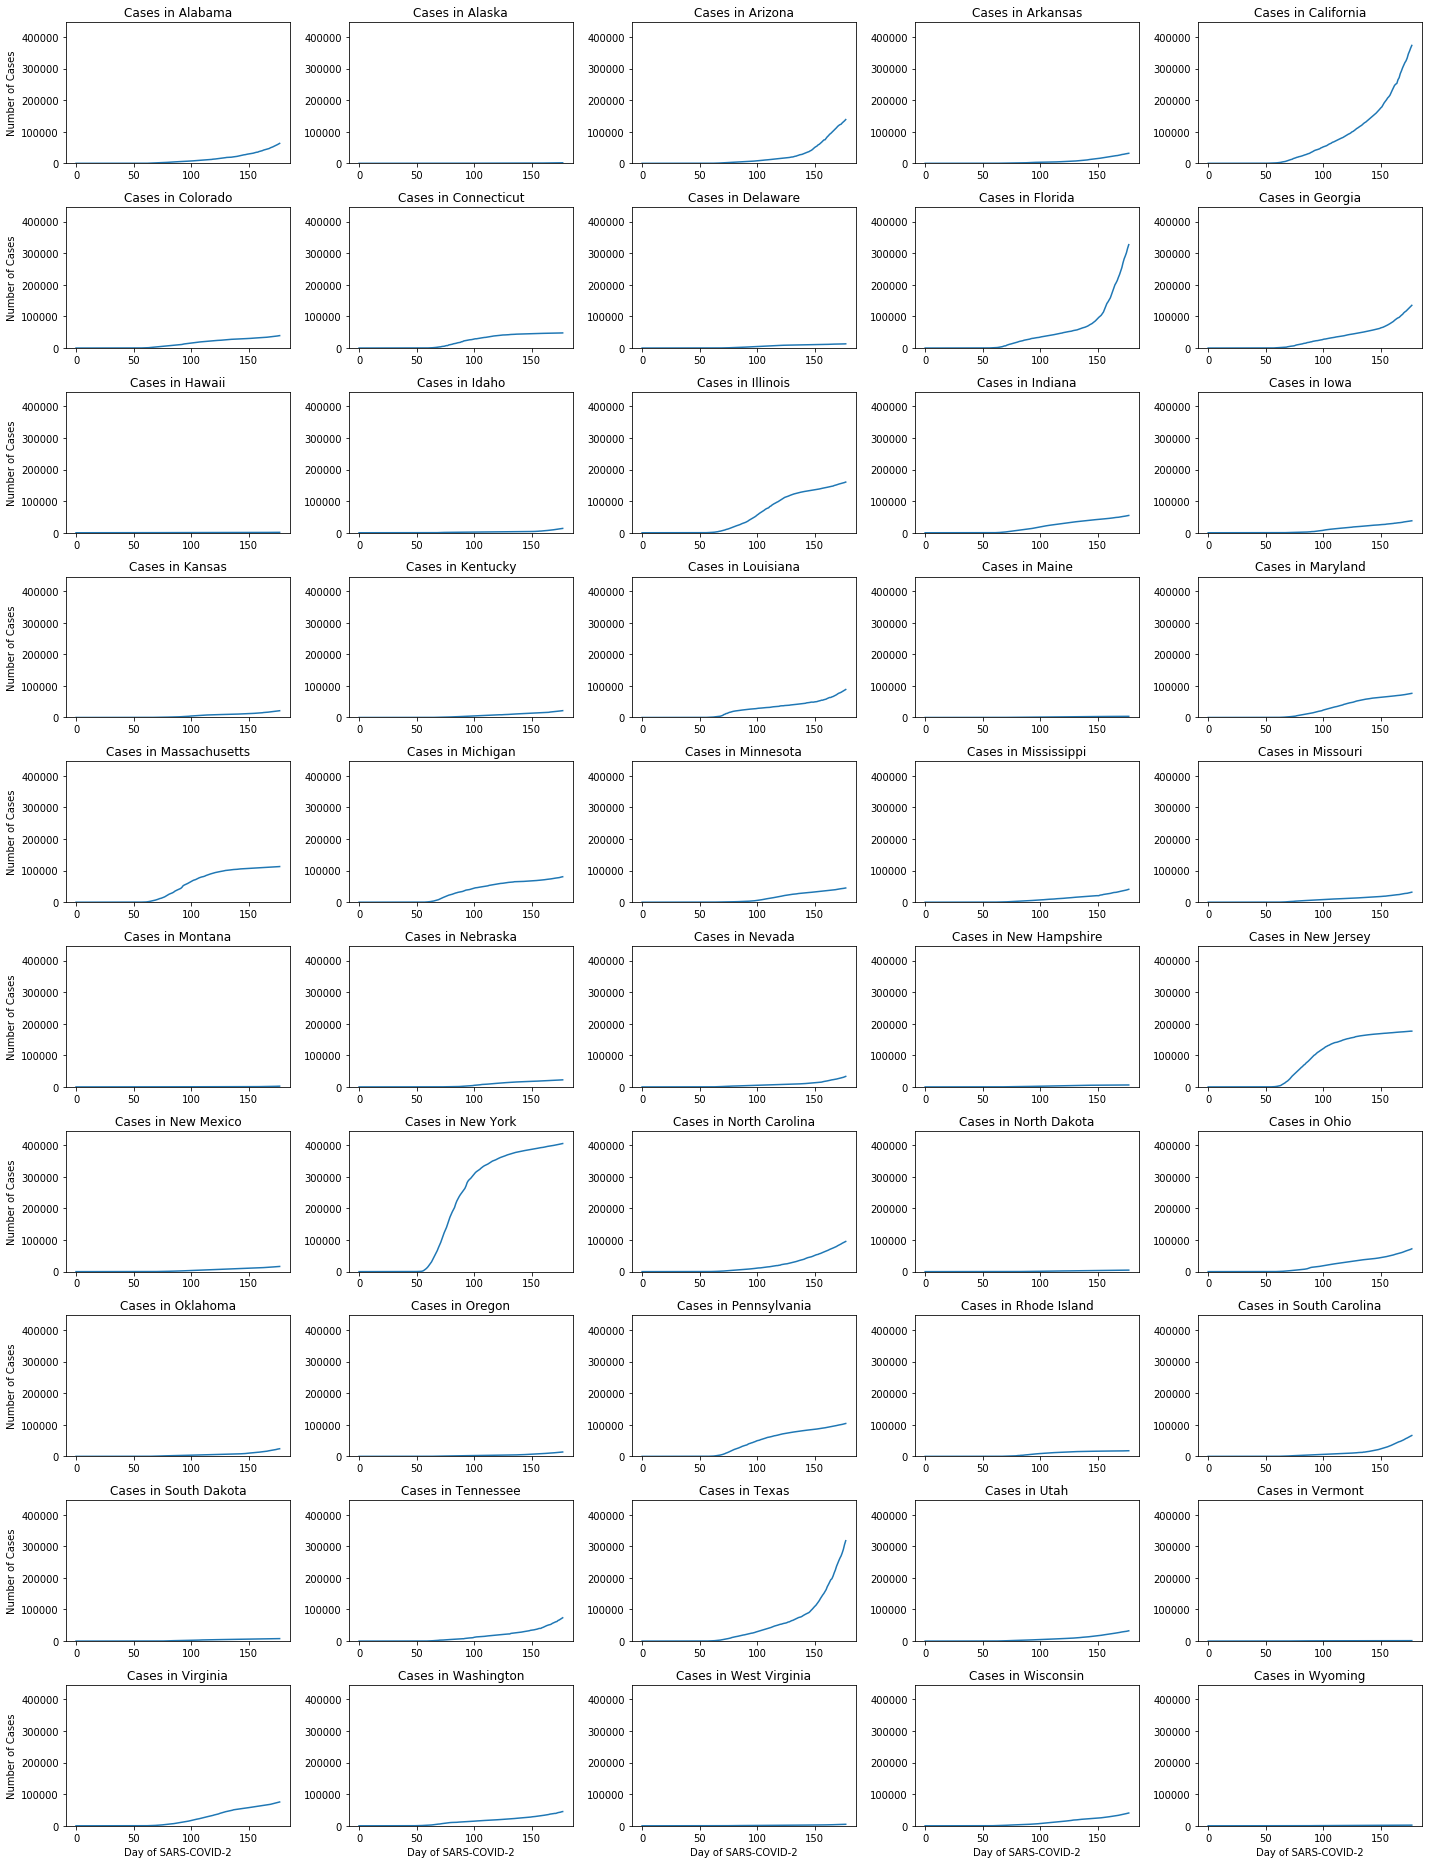

In [73]:
plotCasesByState()

<Figure size 432x288 with 0 Axes>

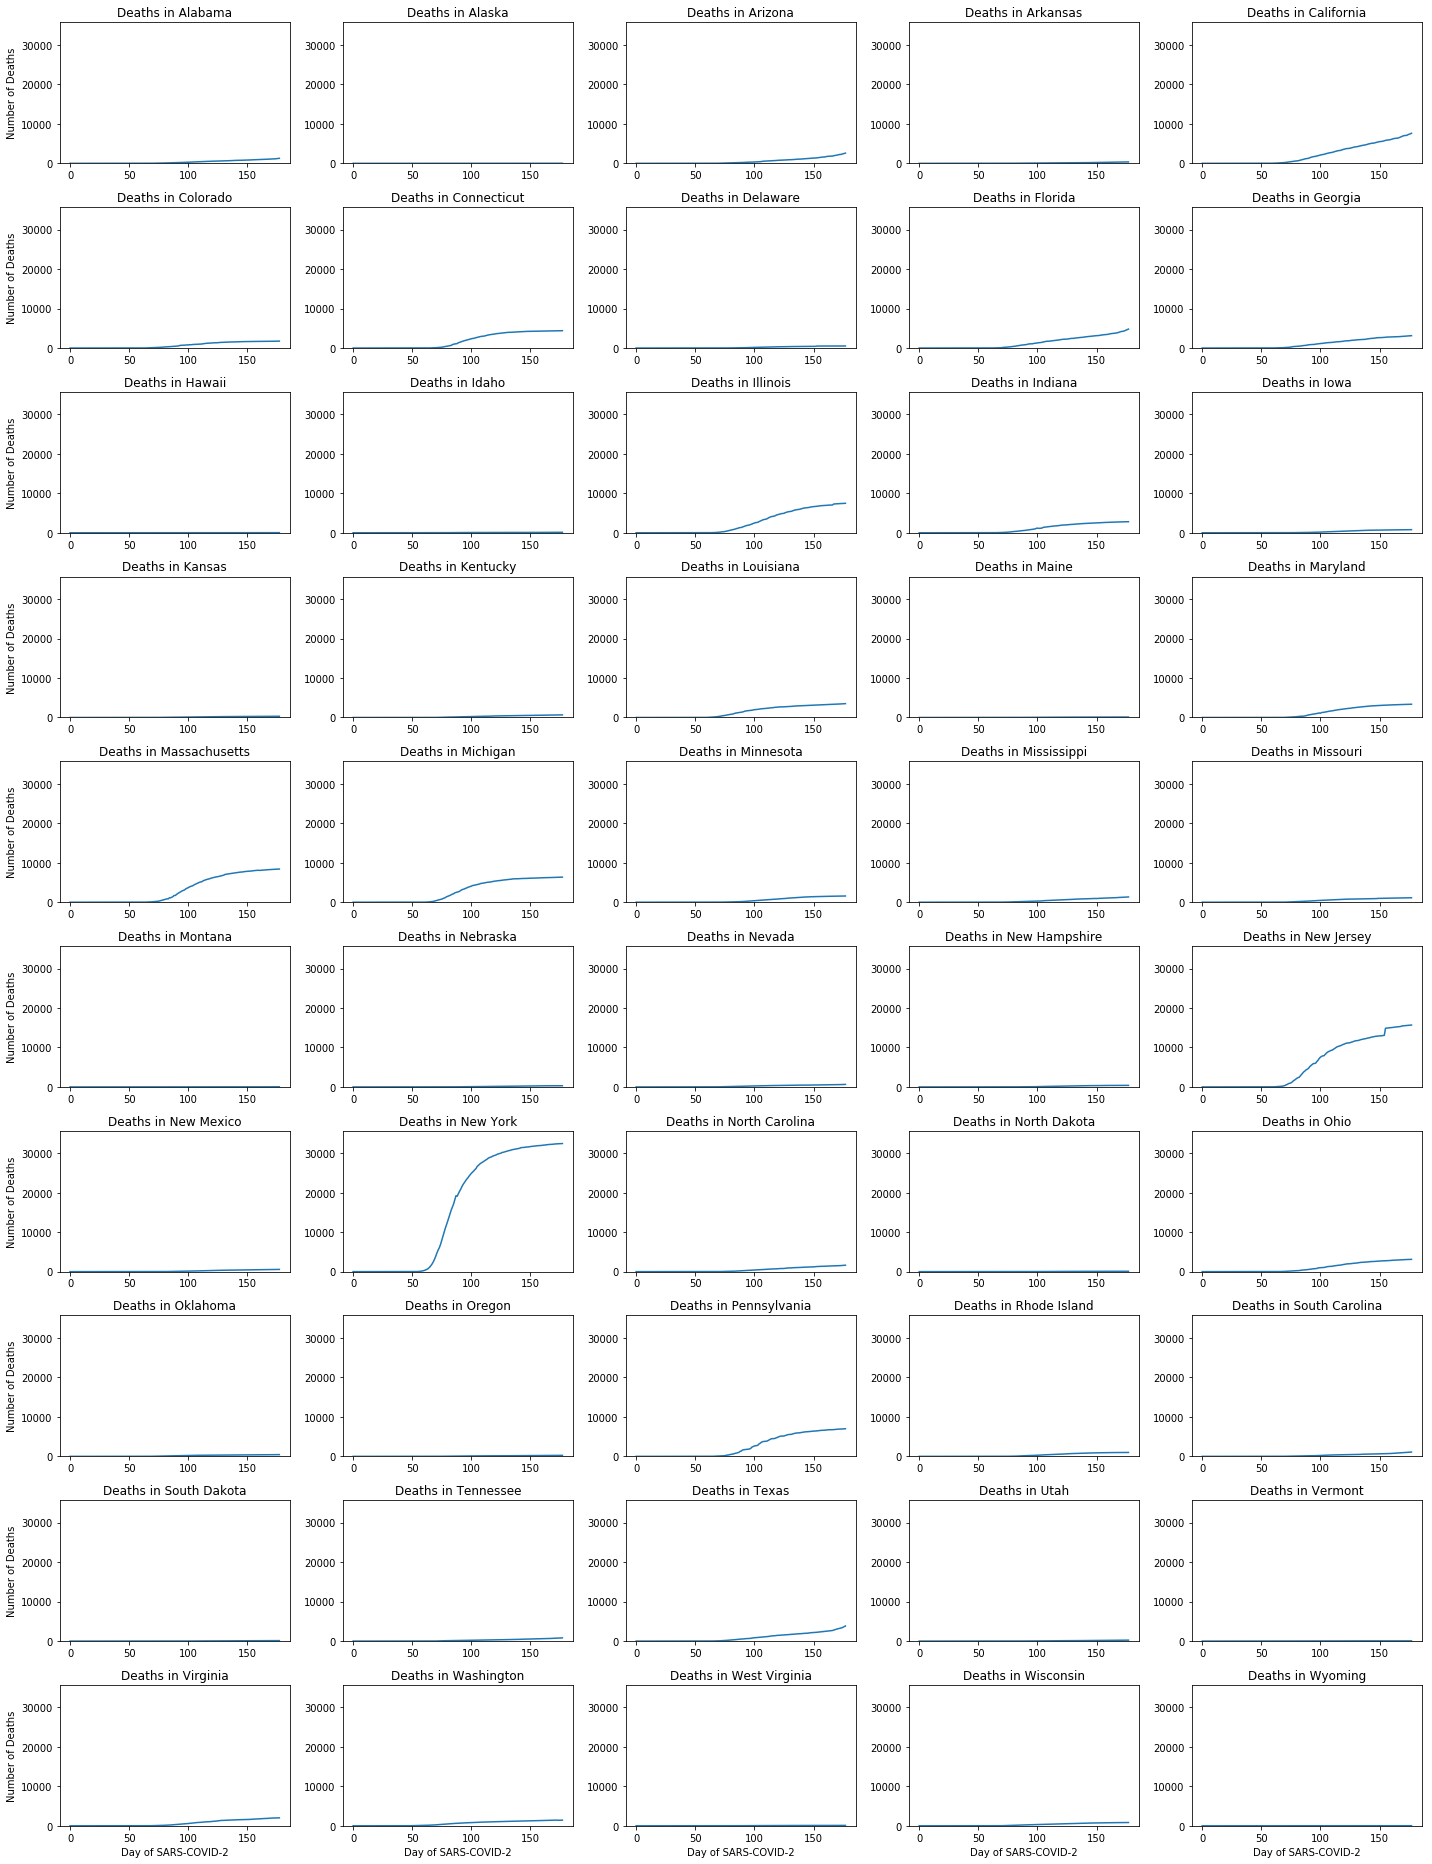

In [77]:
plotDeathsByState()

<Figure size 432x288 with 0 Axes>

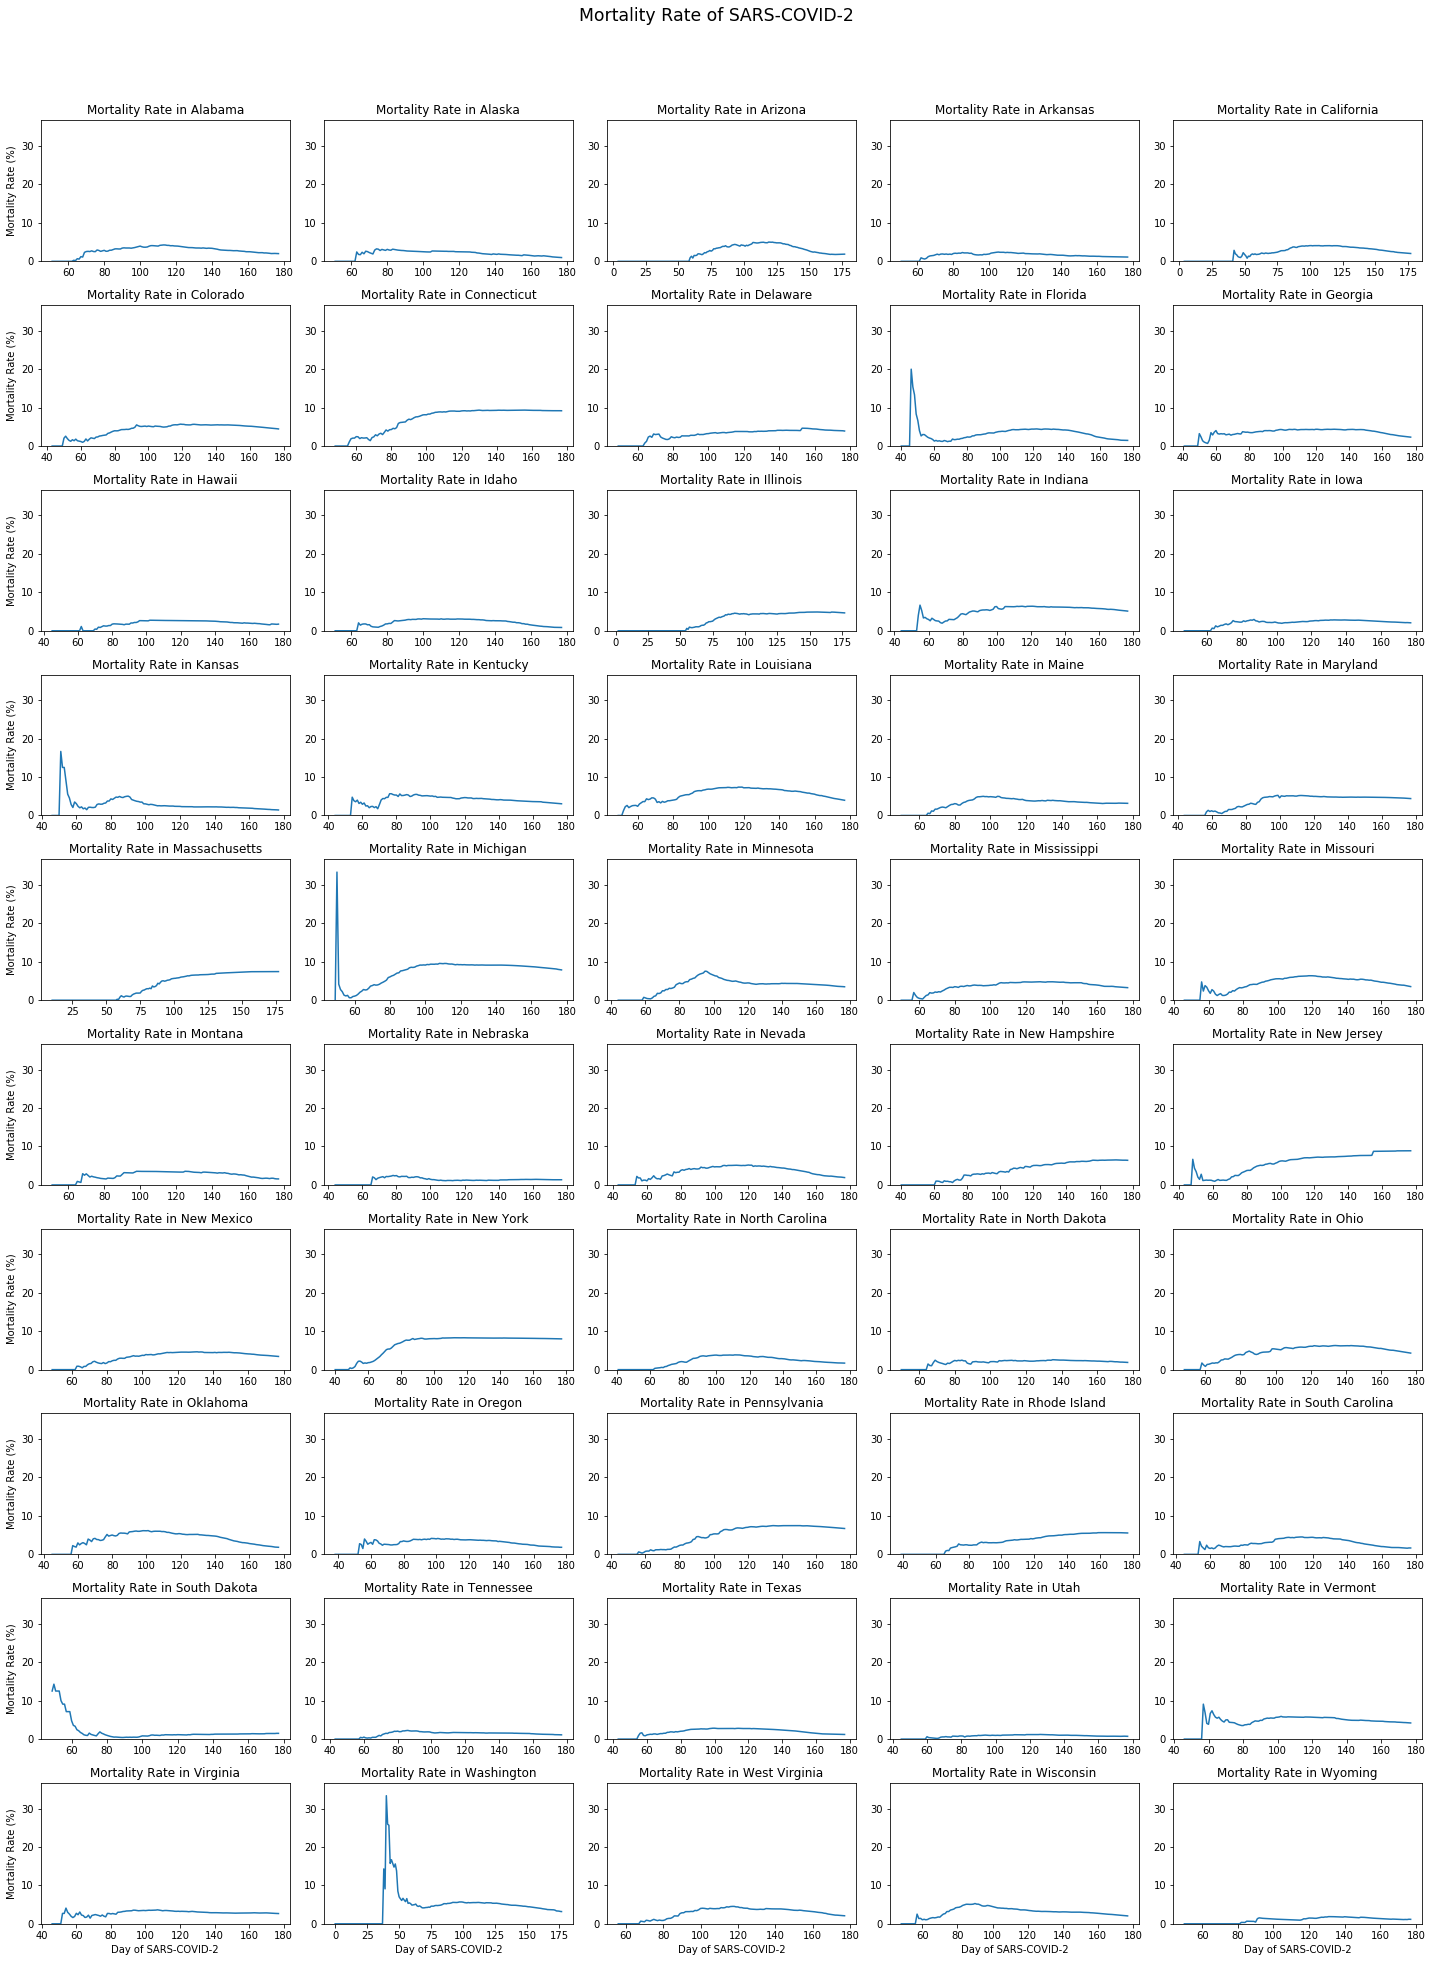

In [78]:
plotMortalityRateByState()

<h4>Scaling the data</h4>

<Figure size 432x288 with 0 Axes>

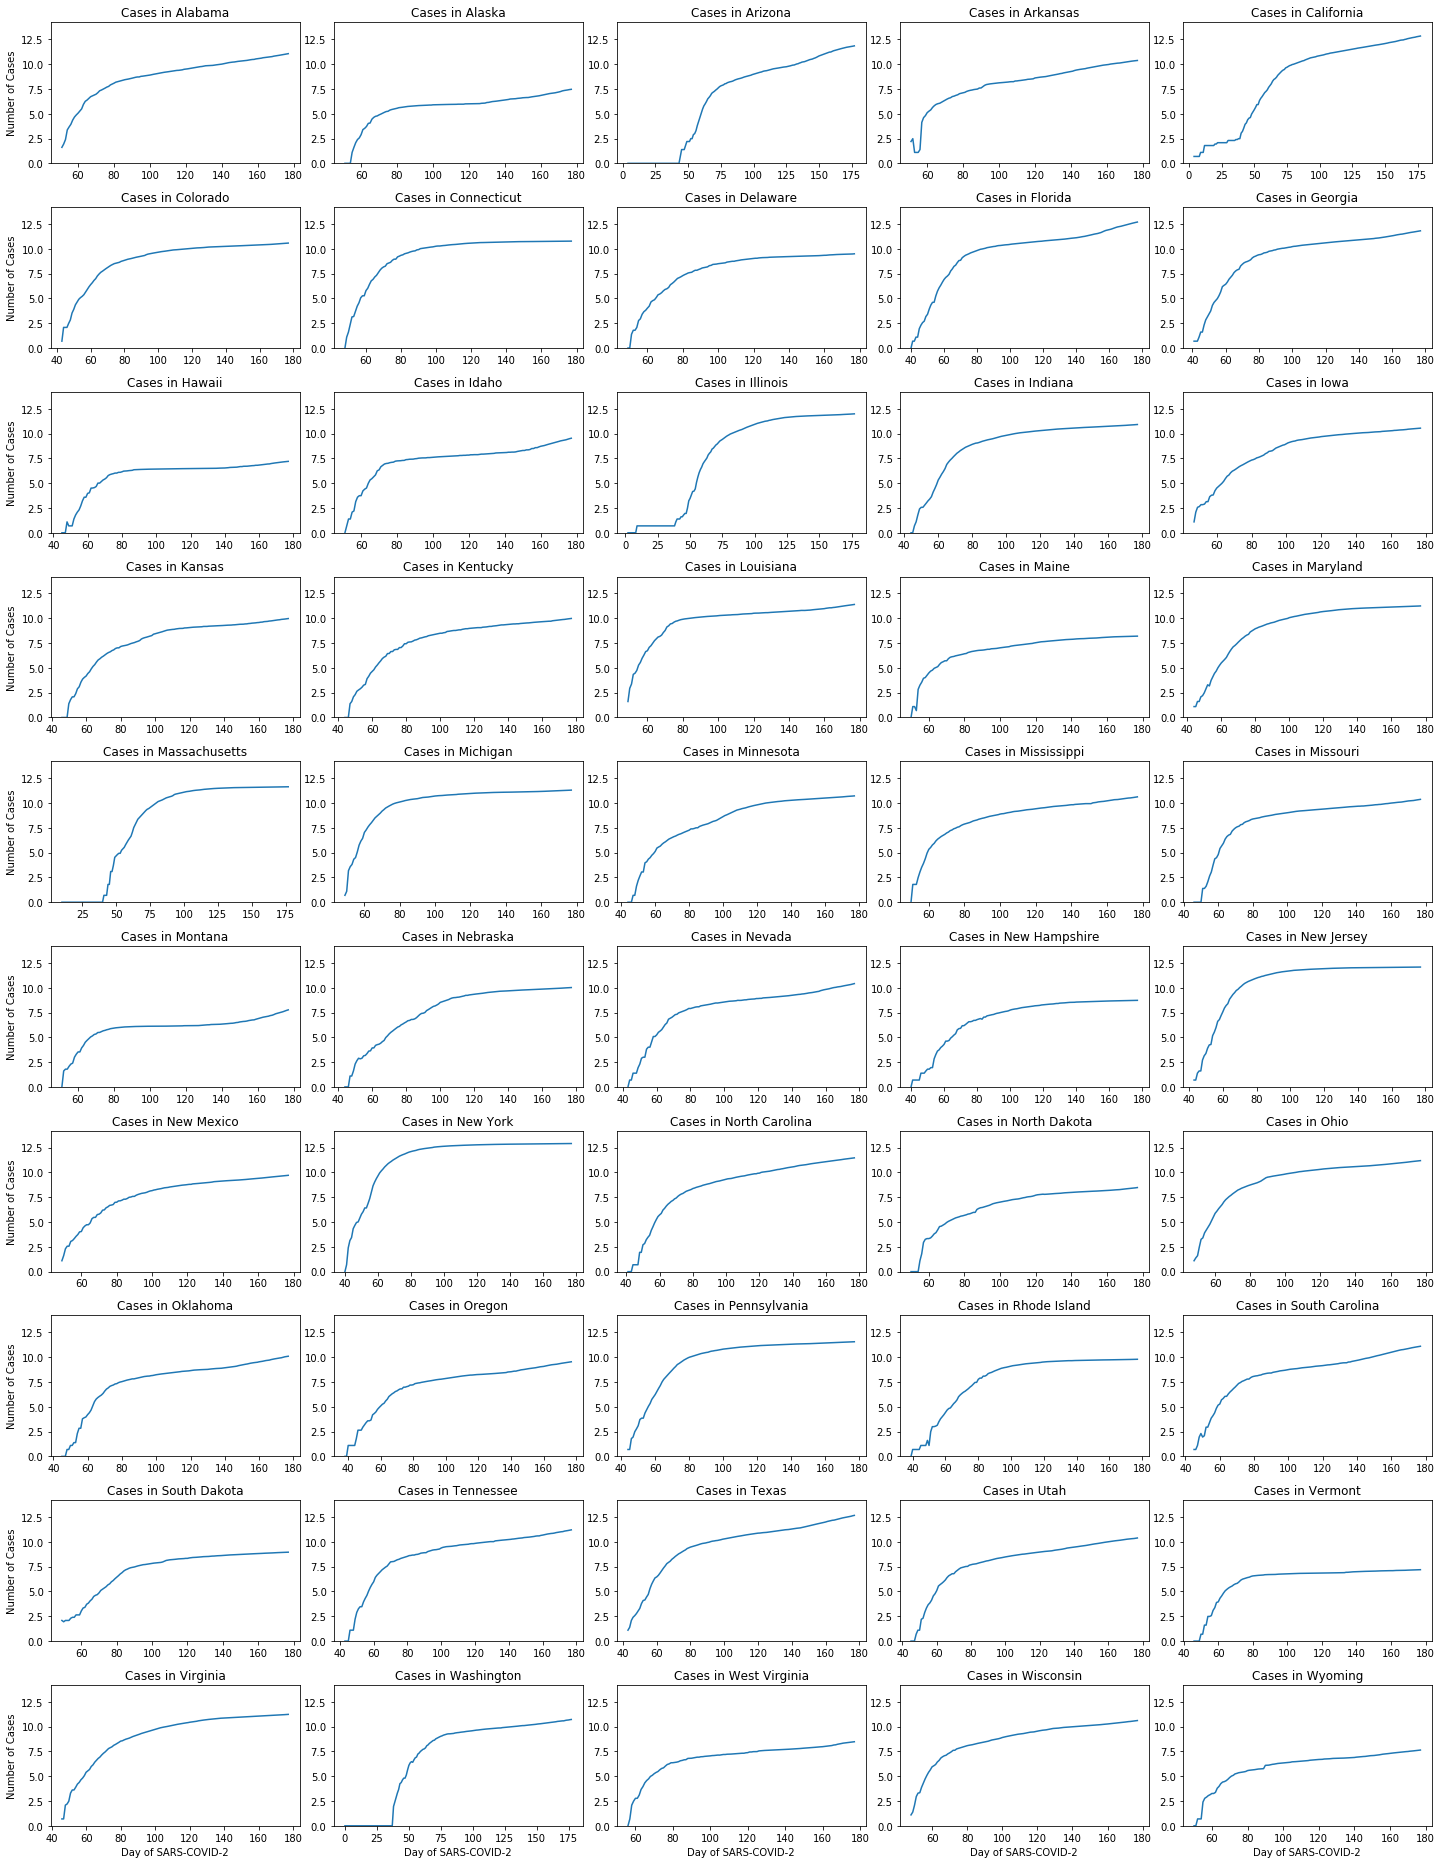

In [79]:
plotCasesByState(logScale=True)

<Figure size 432x288 with 0 Axes>

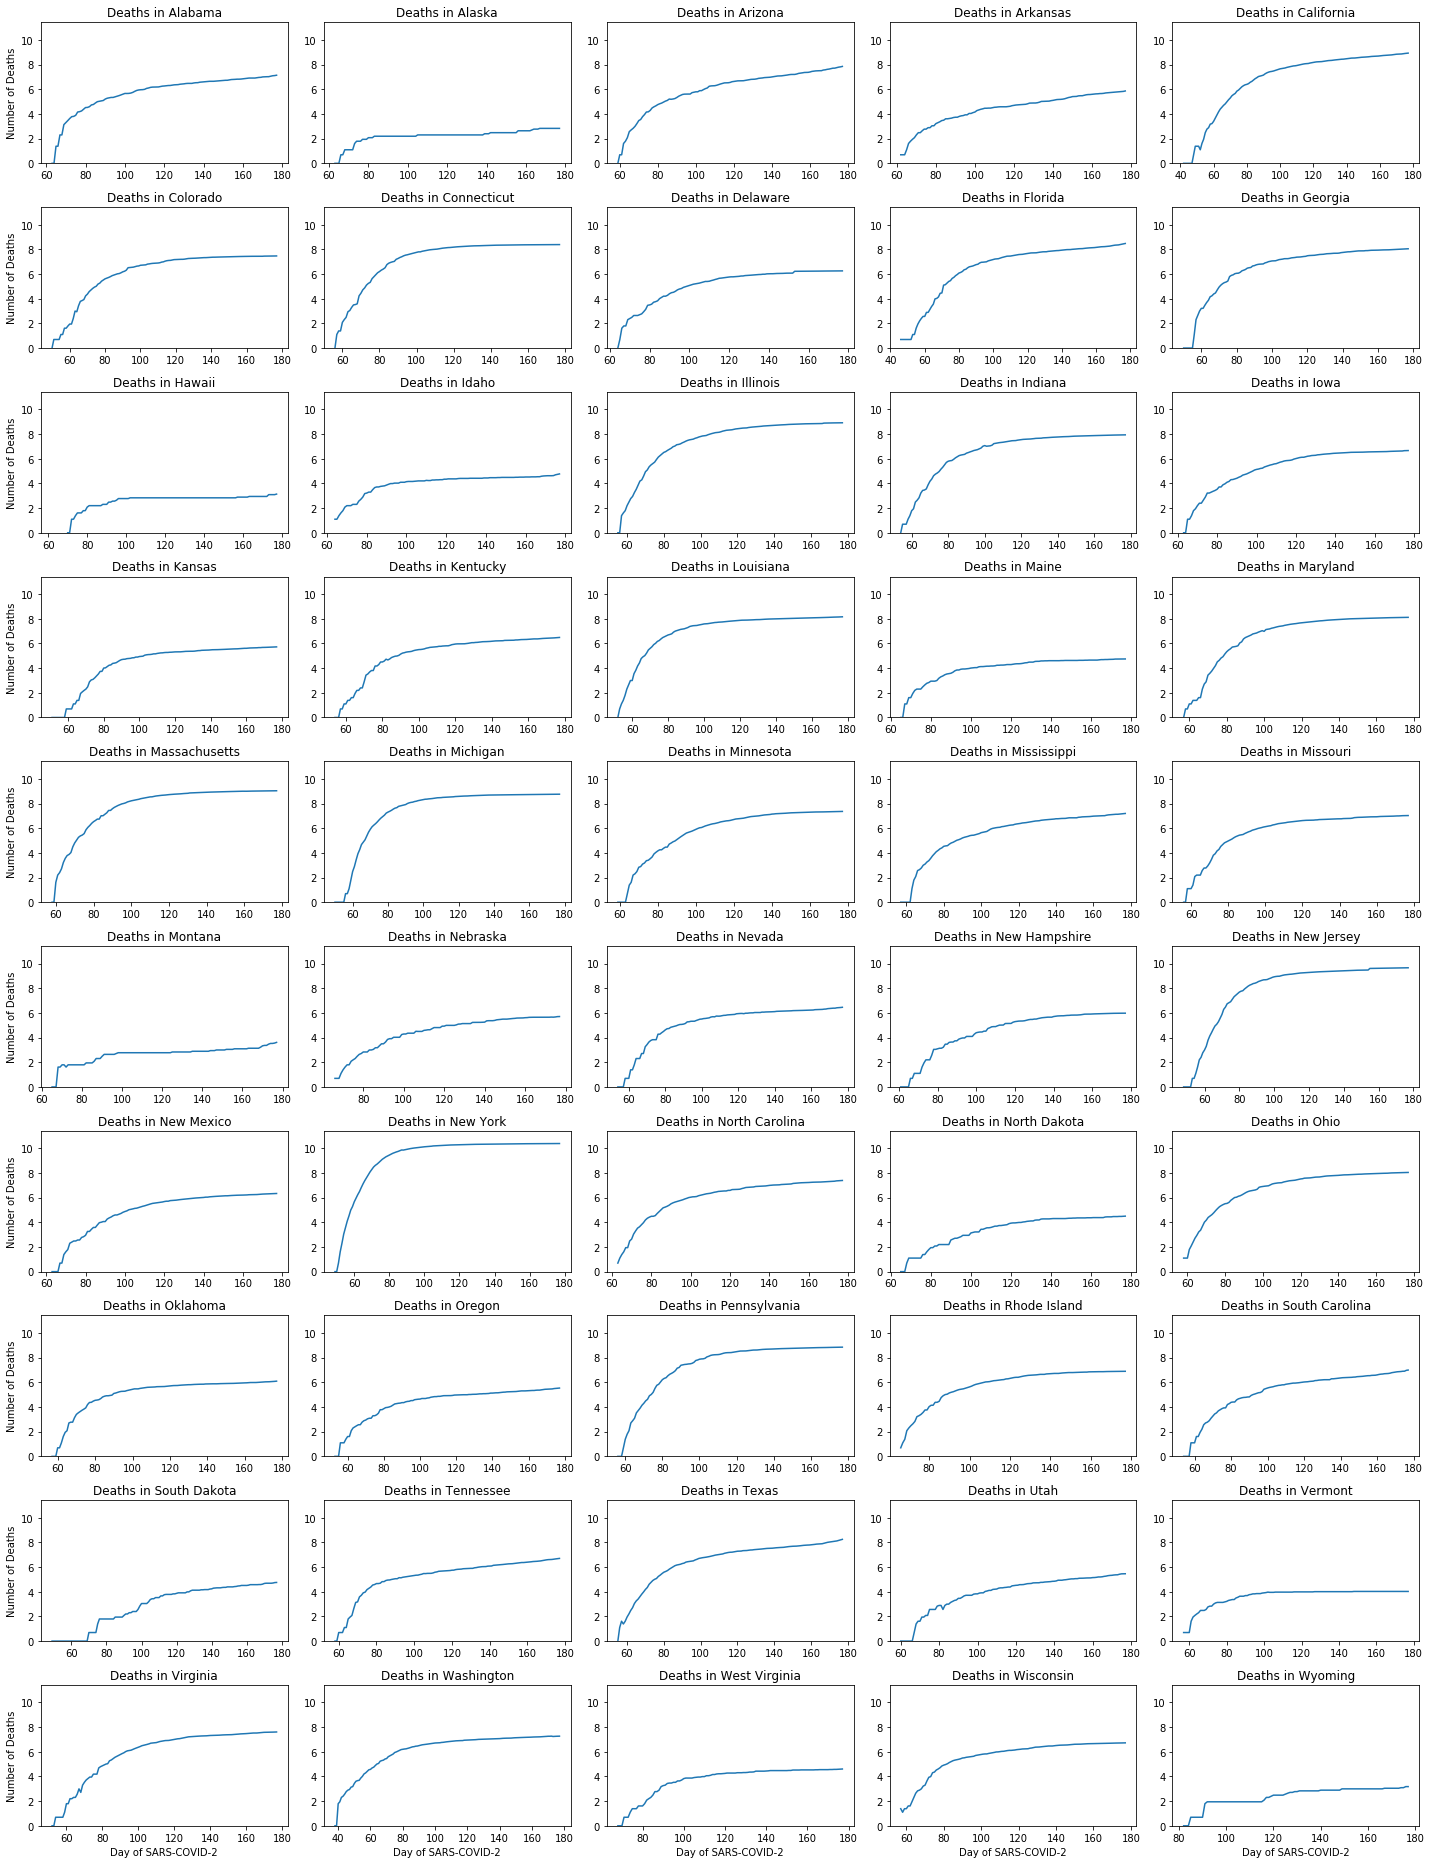

In [80]:
plotDeathsByState(logScale=True)

<h3>Results by Country</h3>

<h4>Raw Data</h4>

In [58]:
# List of countries of interest
countries = [ 'Brazil', 'Canada', 'China', 'Germany', 'Finland',
             'India', 'Iran', 'Italy', 'Japan', 'Korea, South',
             'Norway', 'Switzerland', 'Spain', 'United Kingdom', 'US'
            ]

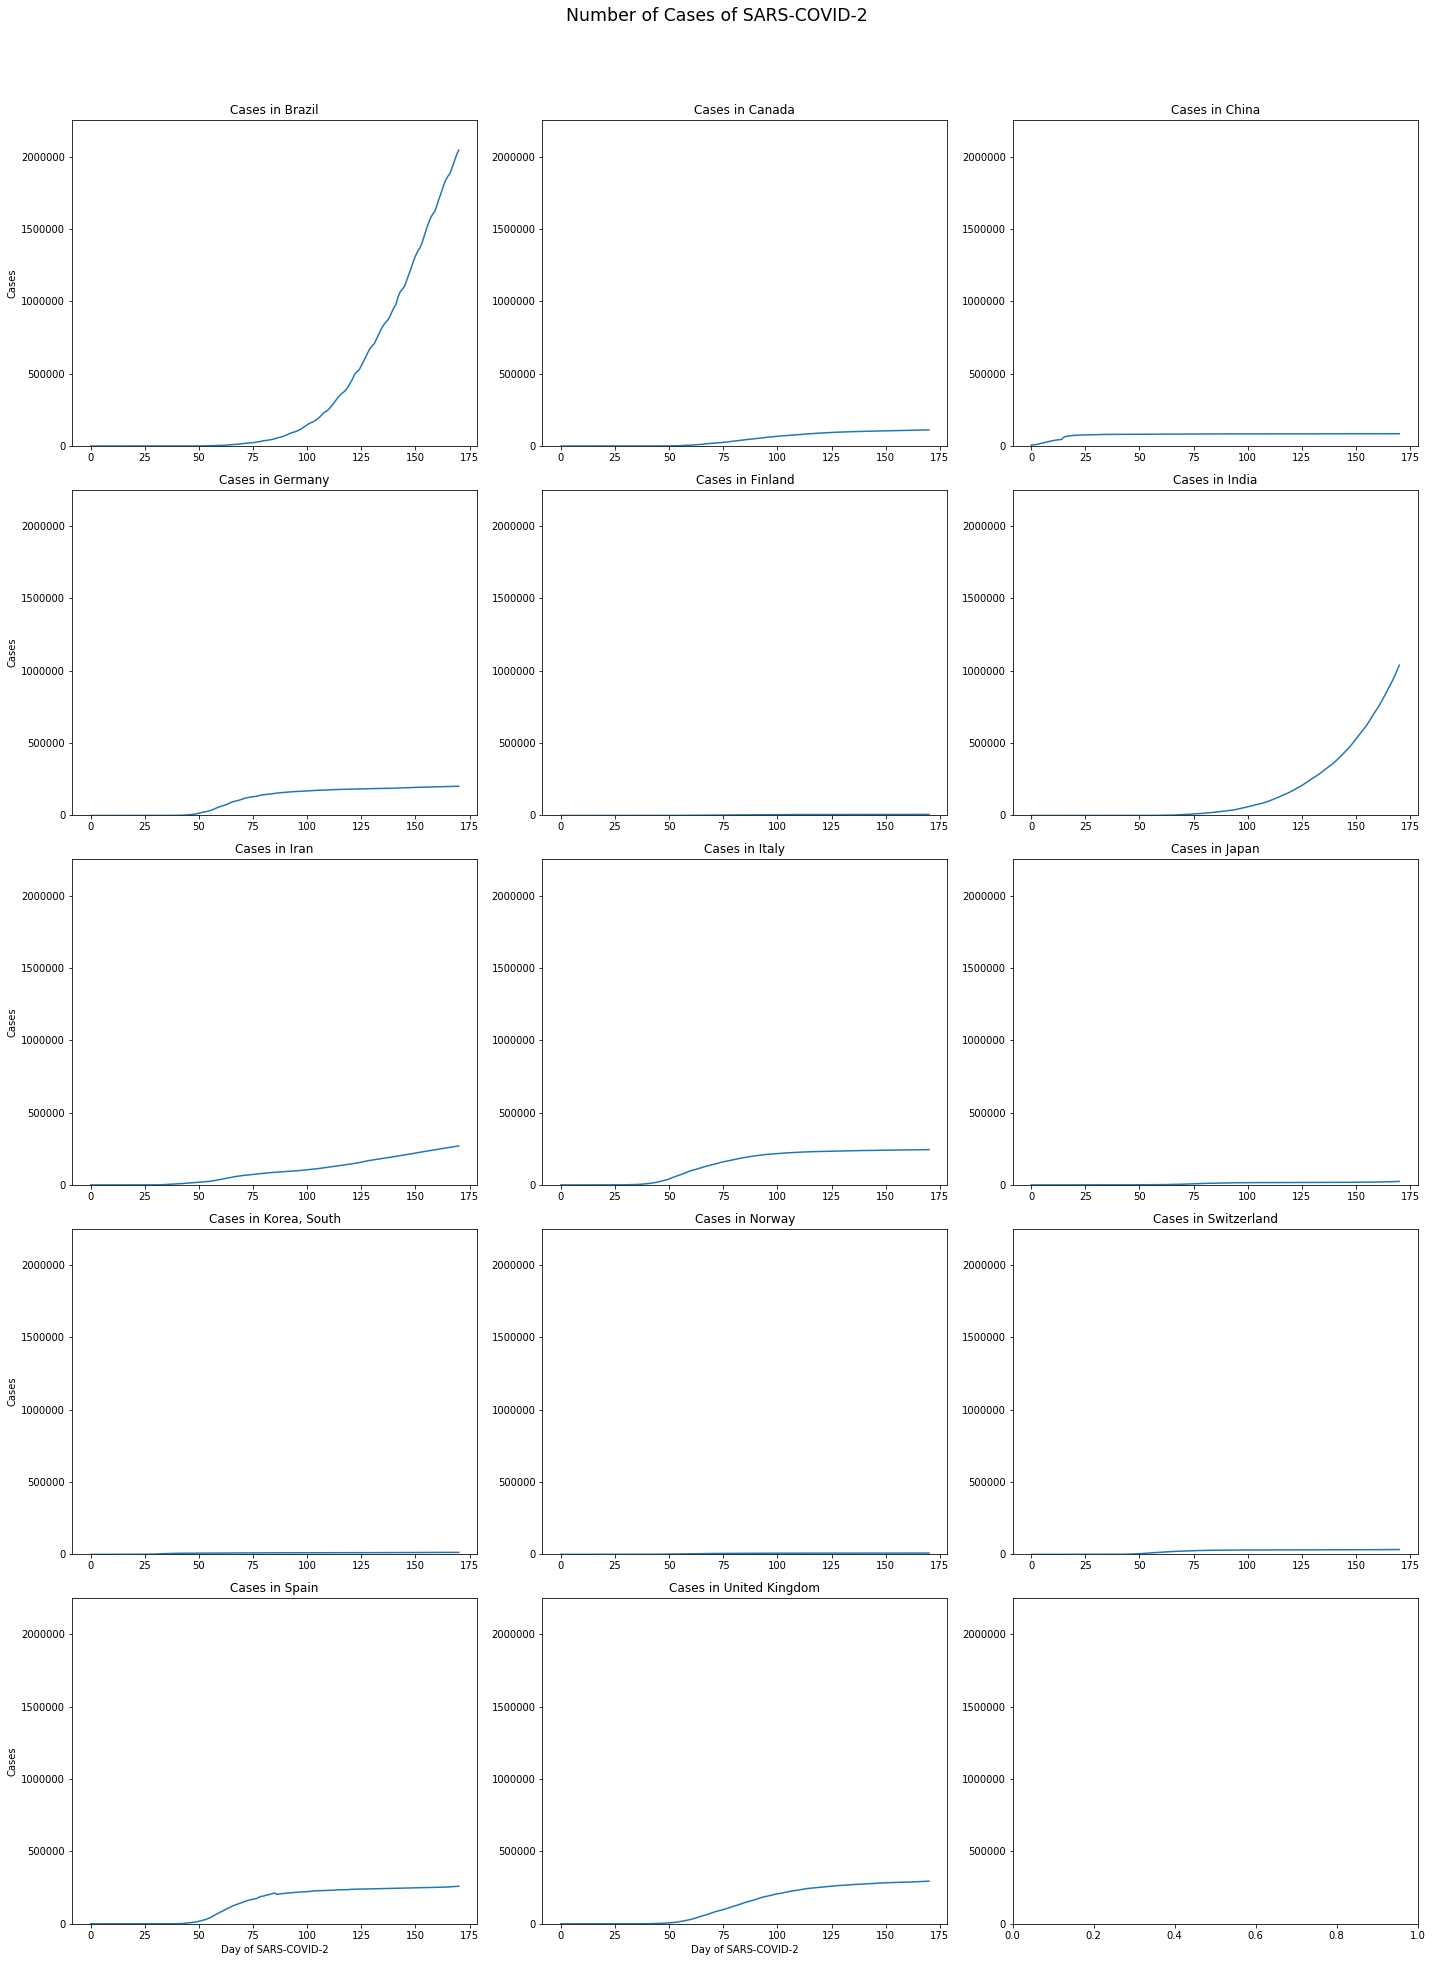

In [81]:
plotCasesByCountry(countries)

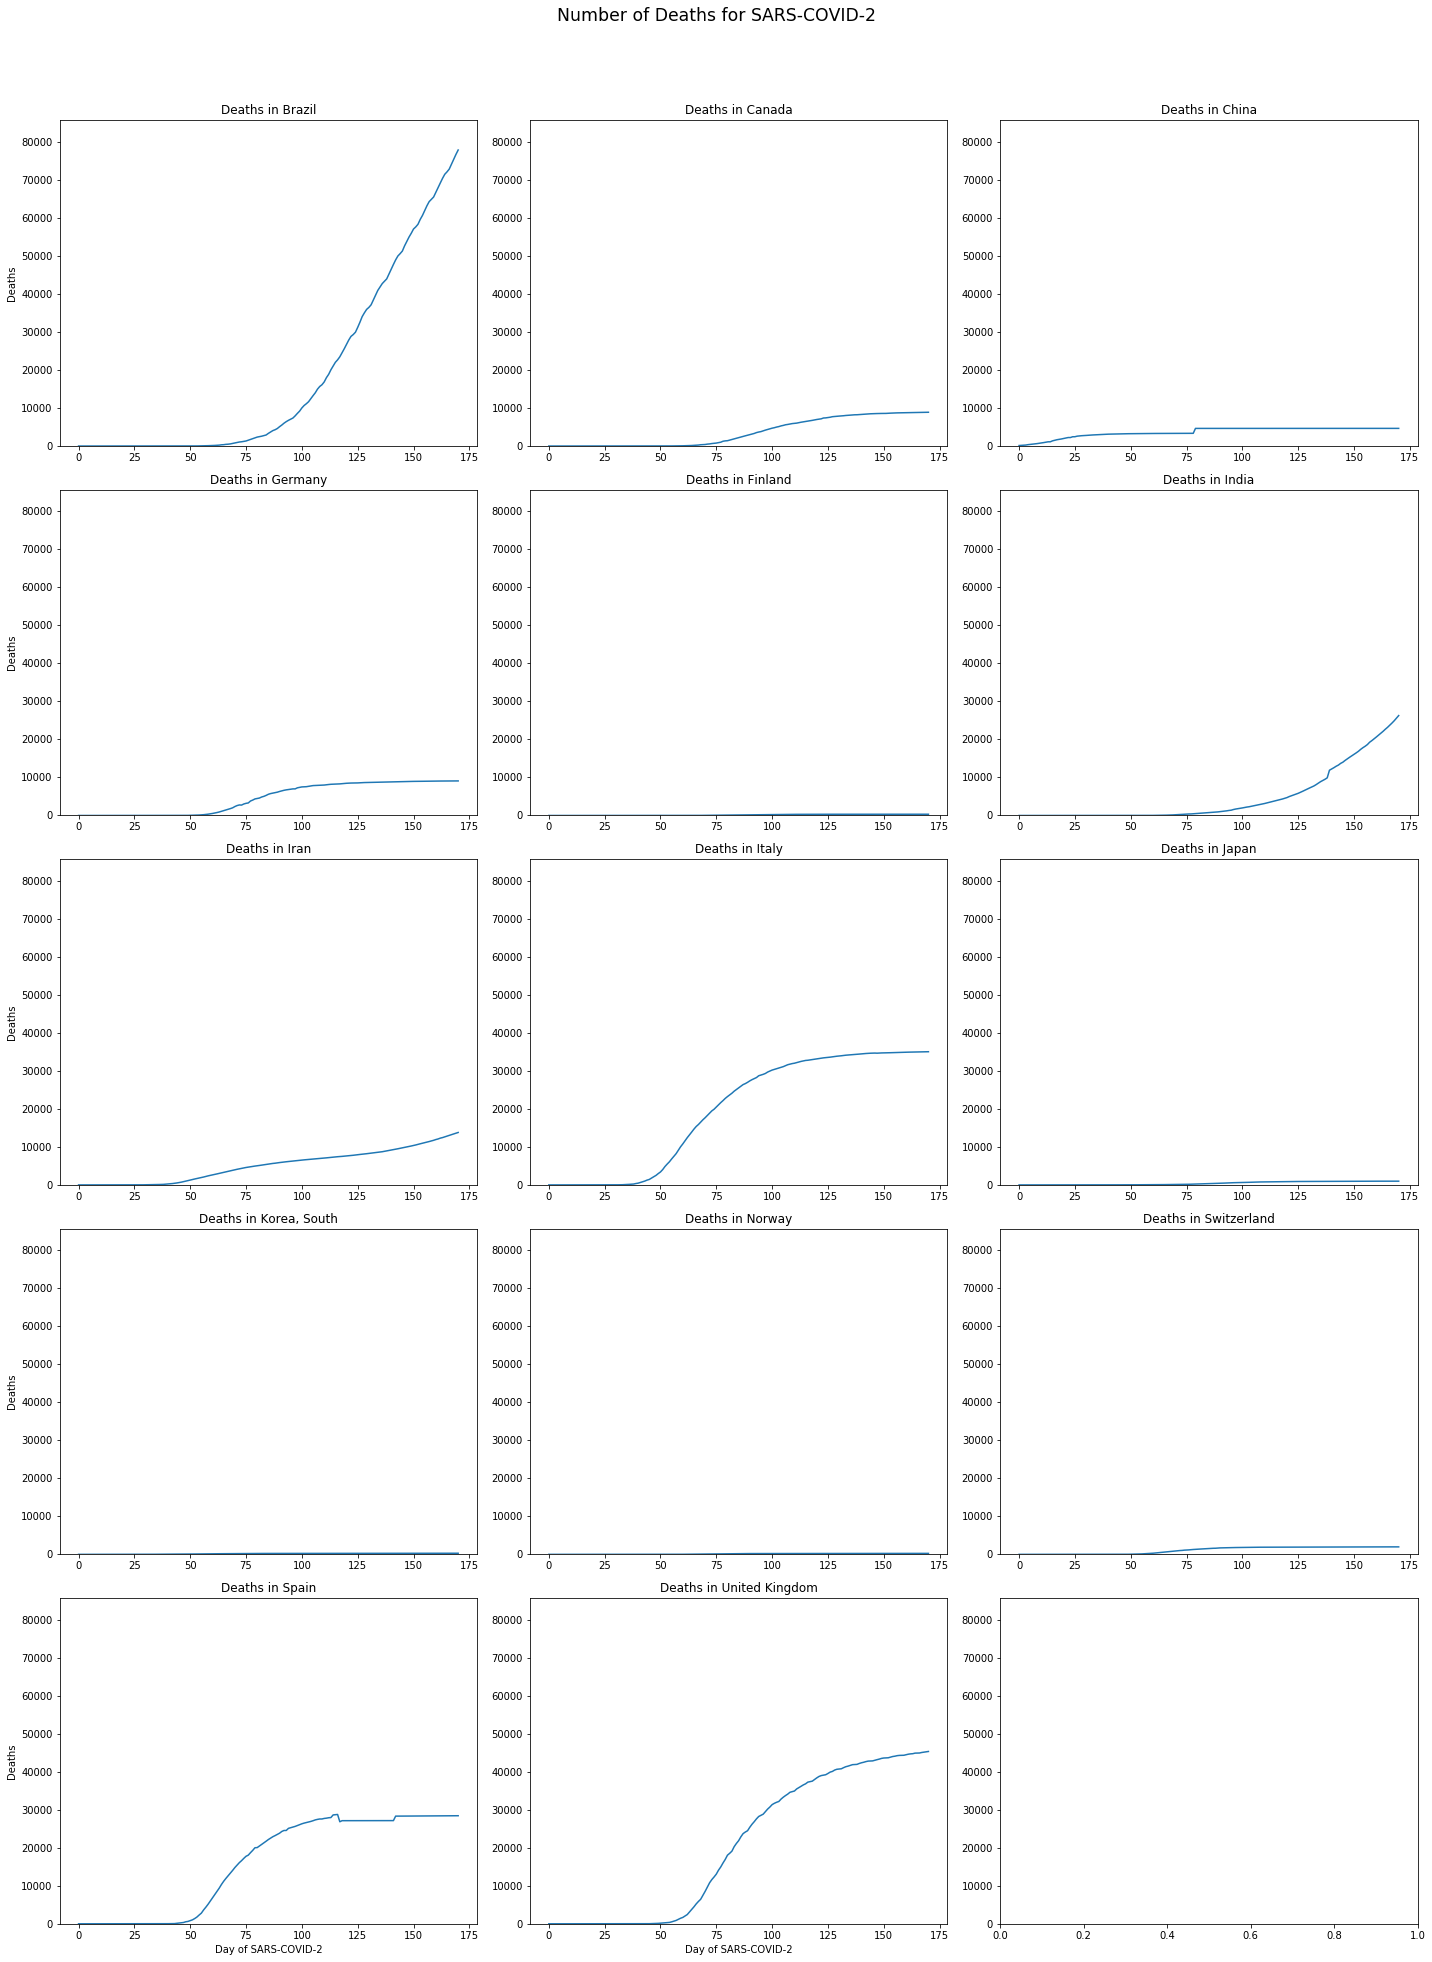

In [82]:
plotDeathsByCountry(countries)

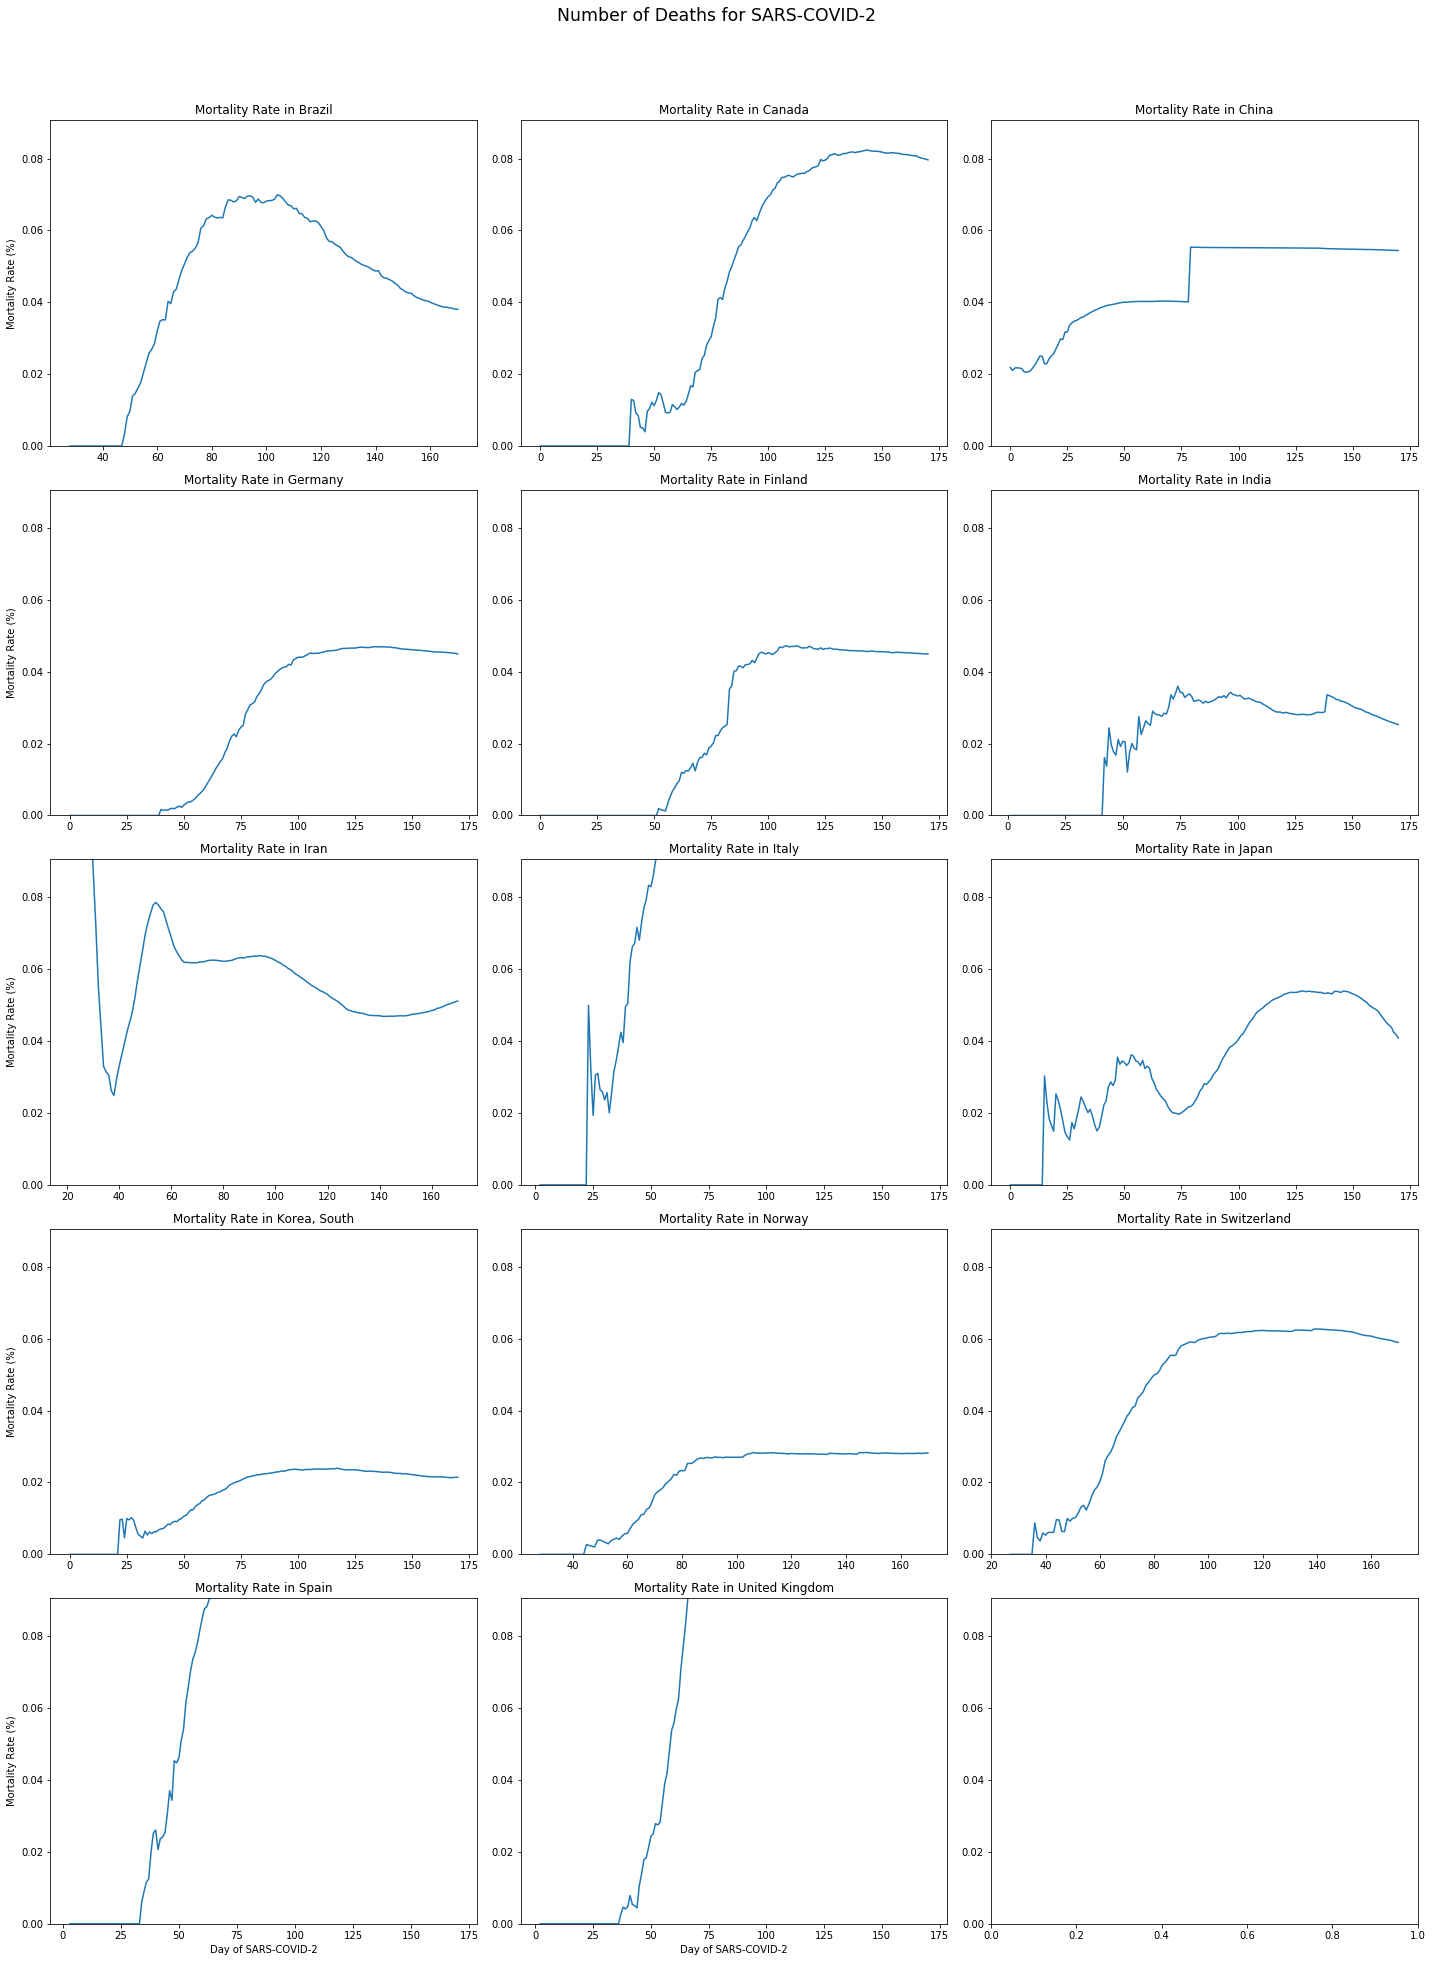

In [83]:
plotMortalityByCountry(countries)

<h4>Scaling the data</h4>

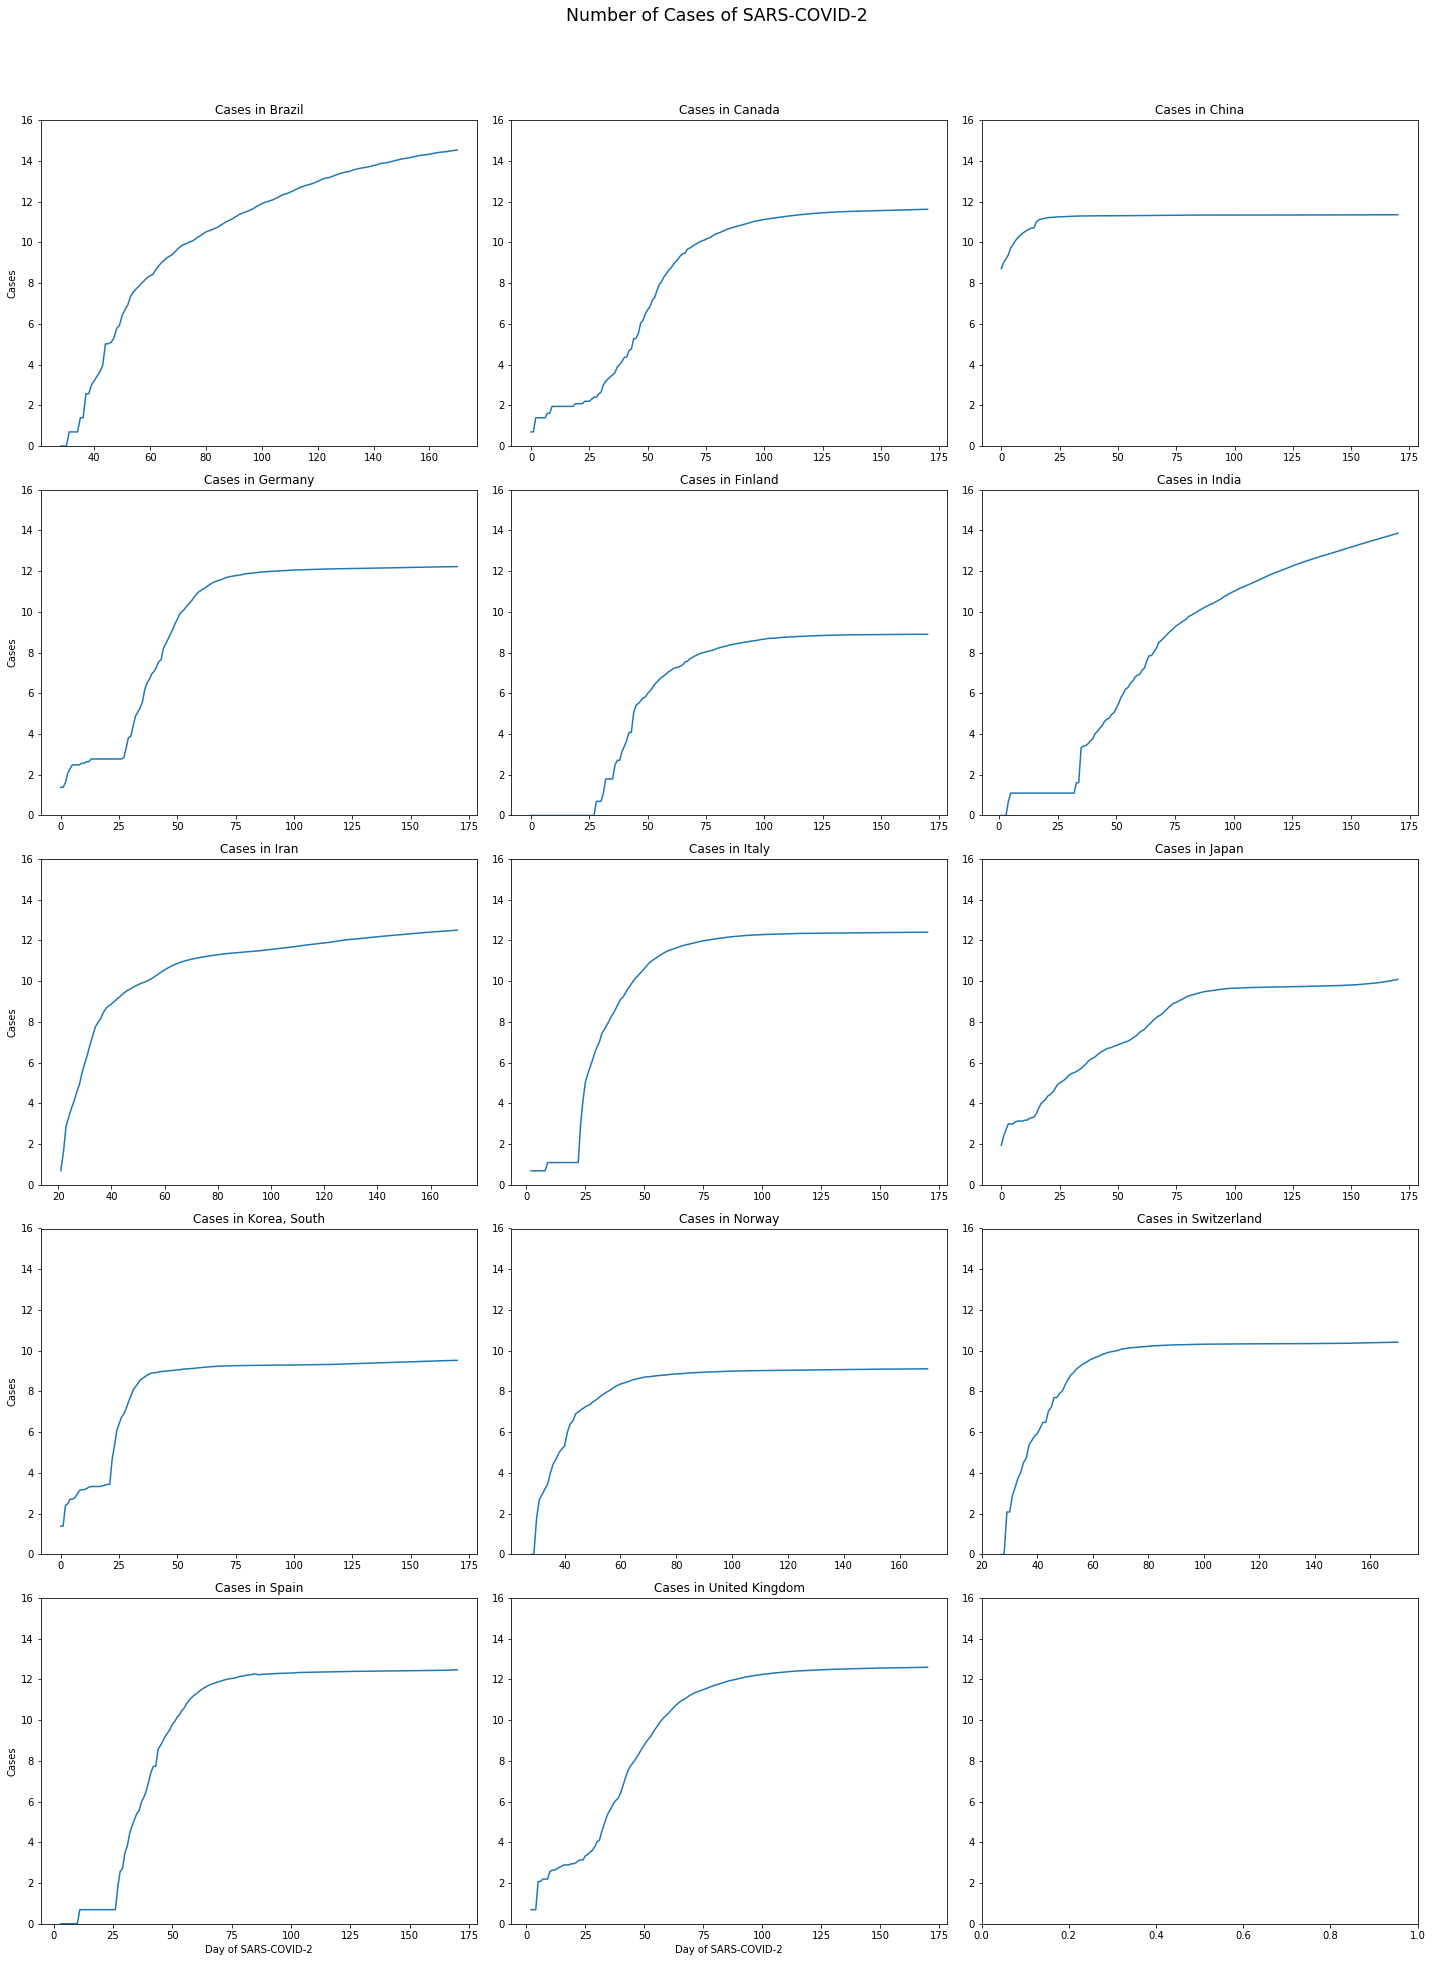

In [84]:
plotCasesByCountry(countries, logScale=True)

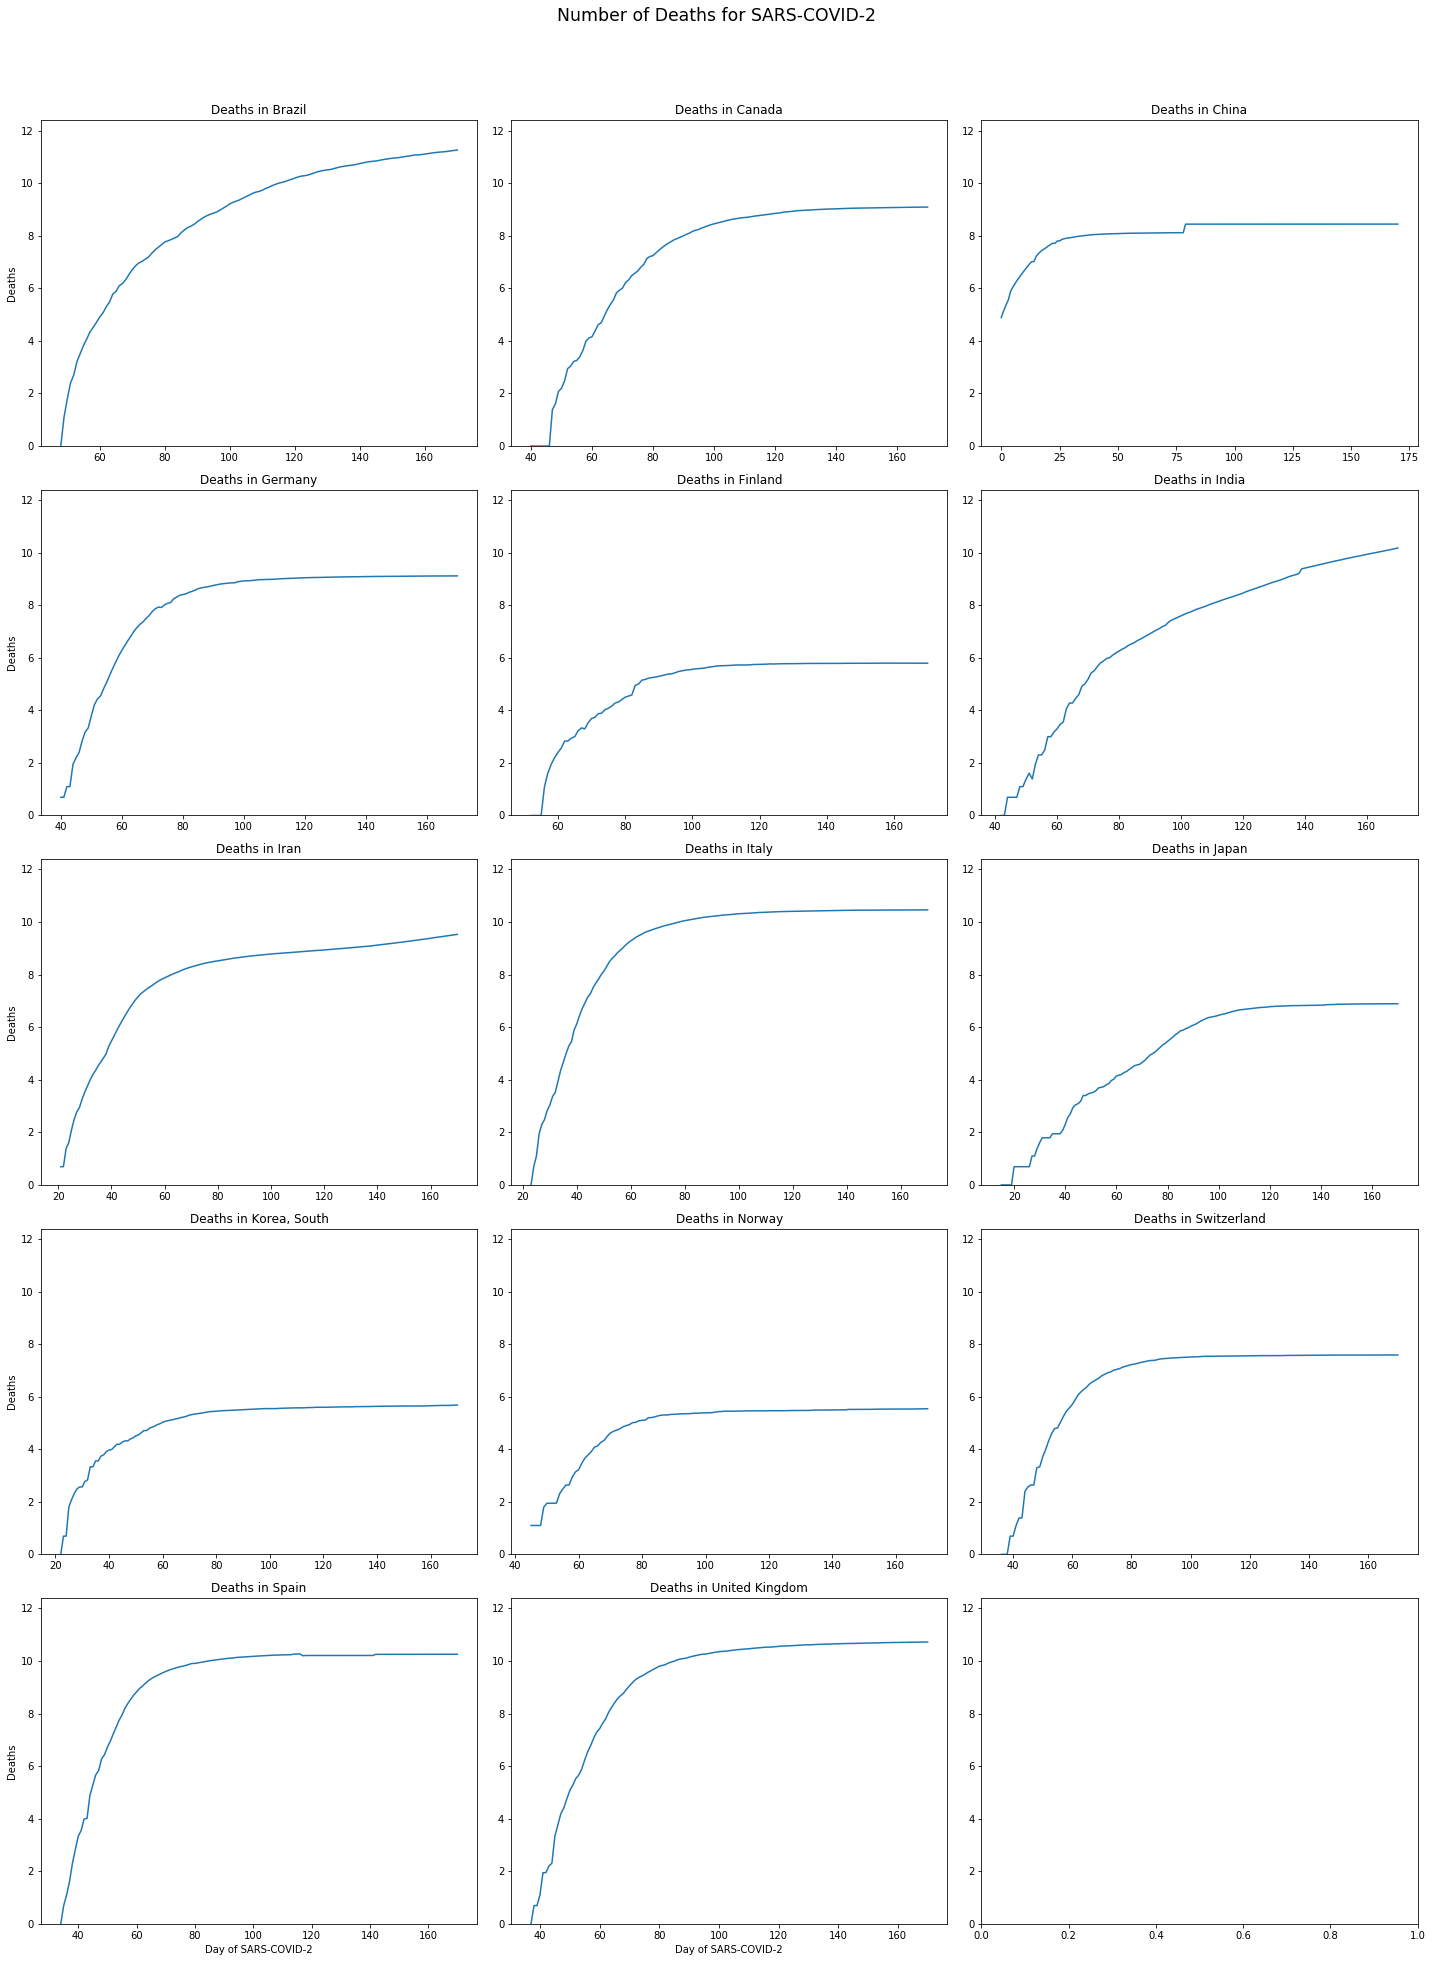

In [85]:
plotDeathsByCountry(countries, logScale=True)

<h2>Conclusions</h2>